In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

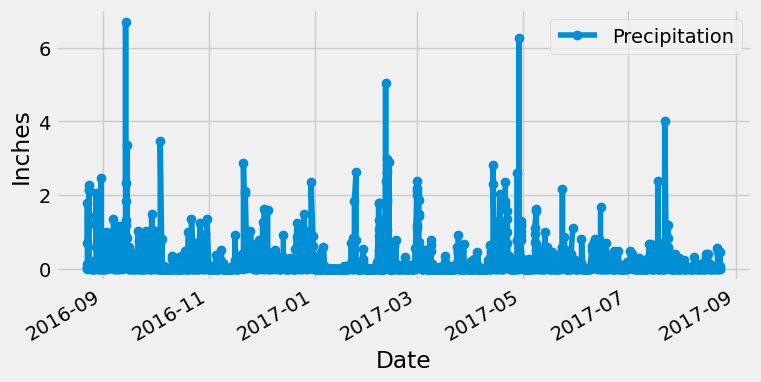

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date_converted = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_previous = latest_date_converted - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_previous
).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
previous_year_precipitation_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])
previous_year_precipitation_df['Date'] = pd.to_datetime(previous_year_precipitation_df['Date'])

# Sort the dataframe by date
previous_year_precipitation_df = previous_year_precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 4))
previous_year_precipitation_df.plot(x='Date', y='Precipitation', kind='line', marker='o', linestyle='-', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(True)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats_df = pd.DataFrame(previous_year_precipitation_df['Precipitation'].describe())
precipitation_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, 
              func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, 
              func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).all()
temperature_stats


[(54.0, 85.0, 71.66378066378067)]

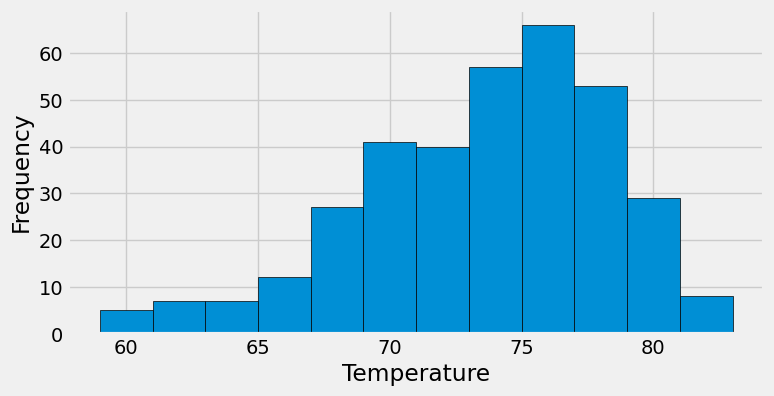

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query: 
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_previous
).all()

temperatures = [tob[0] for tob in temperature_data]

# Plotting:
plt.figure(figsize=(8, 4))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
